## 3. Timeseries Analysis of Reddit Sentiment and Index Prices
This notebook 
1. Reduce Noise in the Sentiment Score with Fourier Transformation 
2. Correlation between Daily Returns and Sentiment Scores
3. Sentiment Scores across a year
4. Boxplots of Seasonal Sentiment Scores 

#### Importing Libraries

In [12]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import numpy as np
import pandas as pd
import csv
import time
import datetime
import warnings 
warnings.filterwarnings("ignore")

In [25]:
df = pd.read_csv('SPYSentiment.csv', parse_dates=['date'], index_col=False)
df

,spy,date,sent
0,269.115723,2018-08-10,-9.8812
1,267.804230,2018-08-15,-17.0701
2,271.501343,2018-08-20,-0.7095
3,271.615356,2018-08-23,5.1418
4,275.407410,2018-08-27,-3.4124
...,...,...,...
481,417.940002,2021-05-10,-26.9461
482,414.209991,2021-05-11,-5.6240
483,405.410004,2021-05-12,-32.2943
484,410.279999,2021-05-13,-0.2195


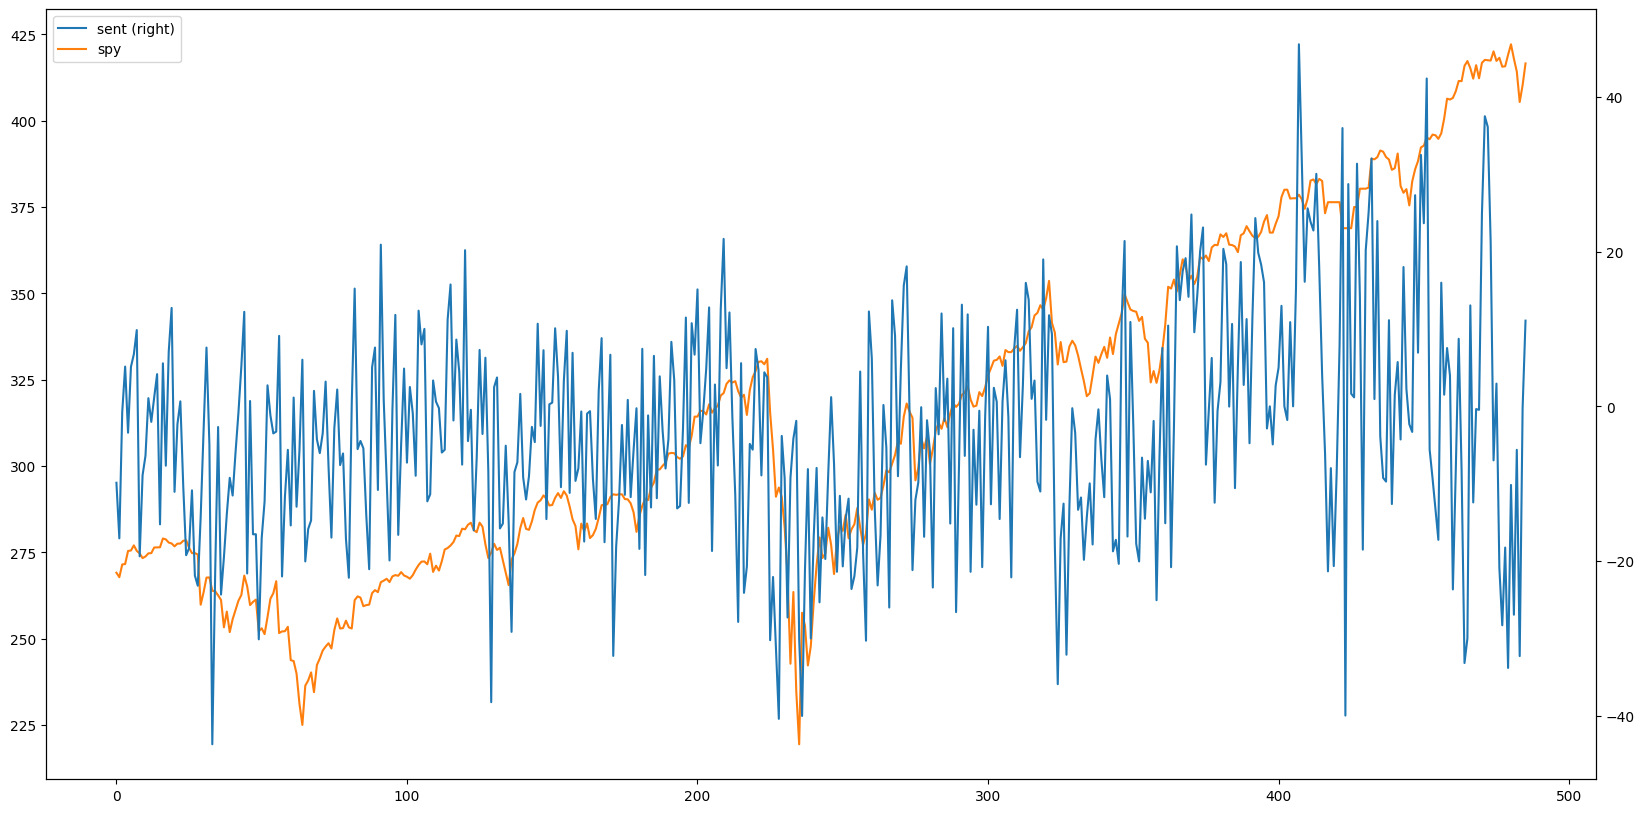

In [26]:
# plot sentiment against price
df[['sent', 'spy']].plot(secondary_y='sent', figsize=(20,10));

#### 3.1 Reduce Noise in the Sentiment Score with Fourier Transformation
Transform sentiment score into a frequency spectrum, remove peaks and extreme lows, convert back into time spectrum. This will remove noise from the sentiment and allow us to spot actual patterns in the data 

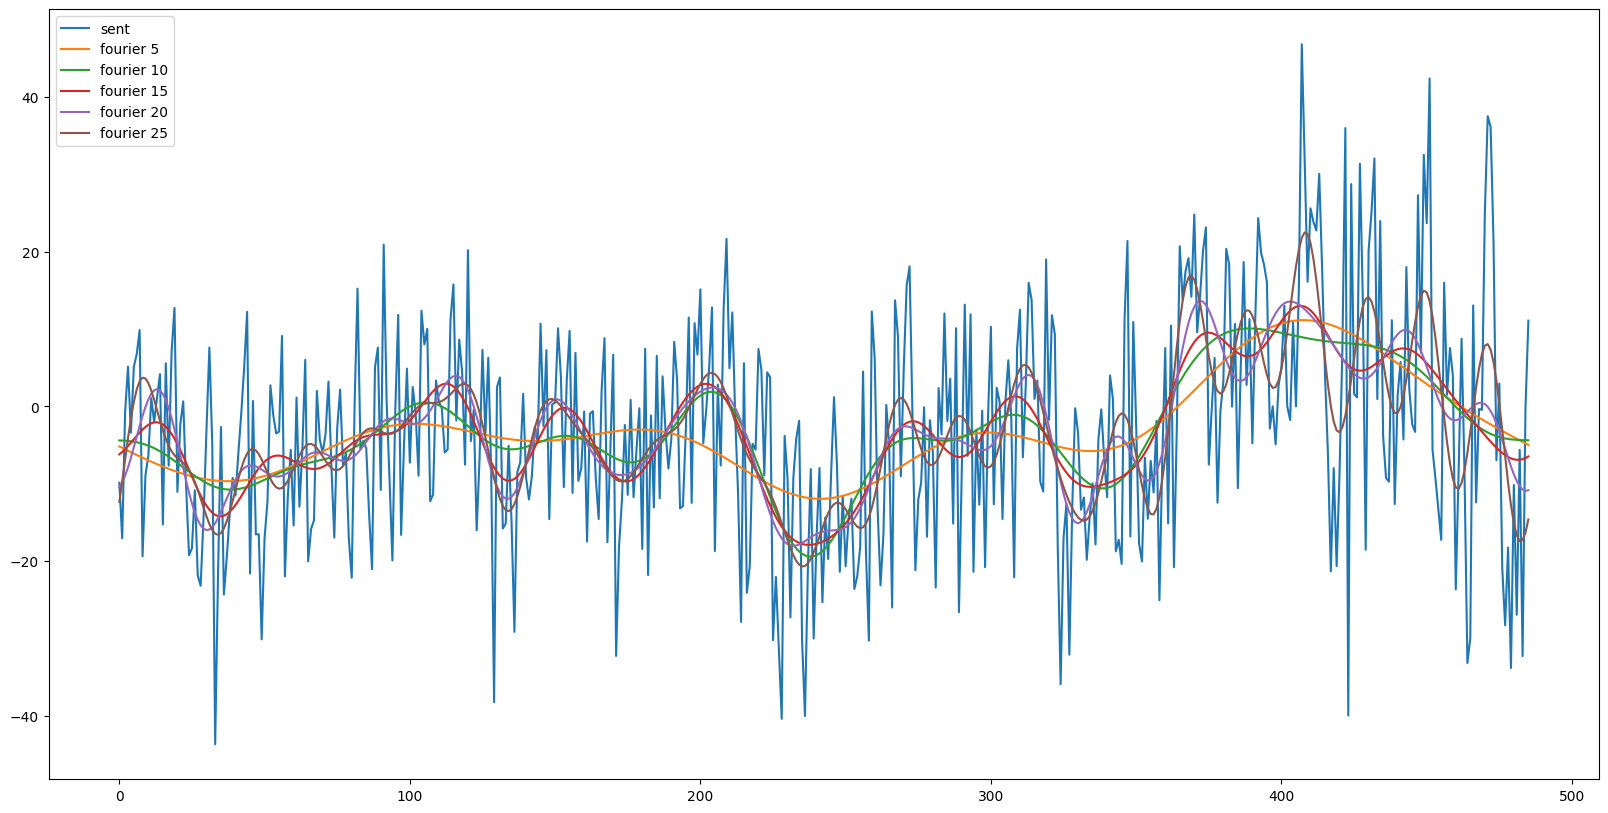

In [42]:
# extract sentiment score as a discrete fourier transform
price_fourier = np.fft.fft(np.asarray(df['sent'].tolist())) # convert sentiment to FFT with numpy
fourier_df = pd.DataFrame({'fourier':price_fourier}) # add to a dataframe
fourier_list = np.asarray(fourier_df['fourier'].tolist())  # extract fourier score as array


for num_ in range(5,30,5): # create fourier columns with scores 20 and 25
    fourier_list_m10= np.copy(fourier_list); fourier_list_m10[num_:-num_]=0 # compund fourier to smoothen signal
    # transform back into time spectrum append each fourier to dataframe with name of fourier
    df['fourier '+str(num_)]=np.fft.ifft(fourier_list_m10) 
    
# plotting sentiment score and fourier transformed scores with different compounds
df[['sent', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20', 'fourier 25']].plot(figsize=(20, 10));

The Fourier 25 compound appears to be the best fit. Will Convert the complex Fourier number to a real number

In [43]:
# adding an normalized number of the fourier transform:
df['sent_smooth'] = df['fourier 25'].apply(lambda x: np.real(x))
# dropping unneeded fourier transforms
df = df.drop(['fourier 5', 'fourier 10', 'fourier 15', 'fourier 20'], axis = 1)
df

,spy,date,sent,fourier 25,sent_smooth,year,month,week,weekday,return %
0,269.115723,2018-08-10,-9.8812,-12.354836+ 0.783686j,-12.354836,2018,Aug,32,Friday,NaN
1,267.804230,2018-08-15,-17.0701,-9.707922+ 0.404149j,-9.707922,2018,Aug,33,Wednesday,0.489721
2,271.501343,2018-08-20,-0.7095,-6.893142- 0.017240j,-6.893142,2018,Aug,34,Monday,-1.361729
3,271.615356,2018-08-23,5.1418,-4.120512- 0.436845j,-4.120512,2018,Aug,34,Thursday,-0.041976
4,275.407410,2018-08-27,-3.4124,-1.582551- 0.811210j,-1.582551,2018,Aug,35,Monday,-1.376889
...,...,...,...,...,...,...,...,...,...,...
481,417.940002,2021-05-10,-26.9461,-16.698179+ 1.030670j,-16.698179,2021,May,19,Monday,1.000142
482,414.209991,2021-05-11,-5.6240,-17.434043+ 1.241288j,-17.434043,2021,May,19,Tuesday,0.900512
483,405.410004,2021-05-12,-32.2943,-17.294306+ 1.323361j,-17.294306,2021,May,19,Wednesday,2.170639
484,410.279999,2021-05-13,-0.2195,-16.322324+ 1.268389j,-16.322324,2021,May,19,Thursday,-1.186993


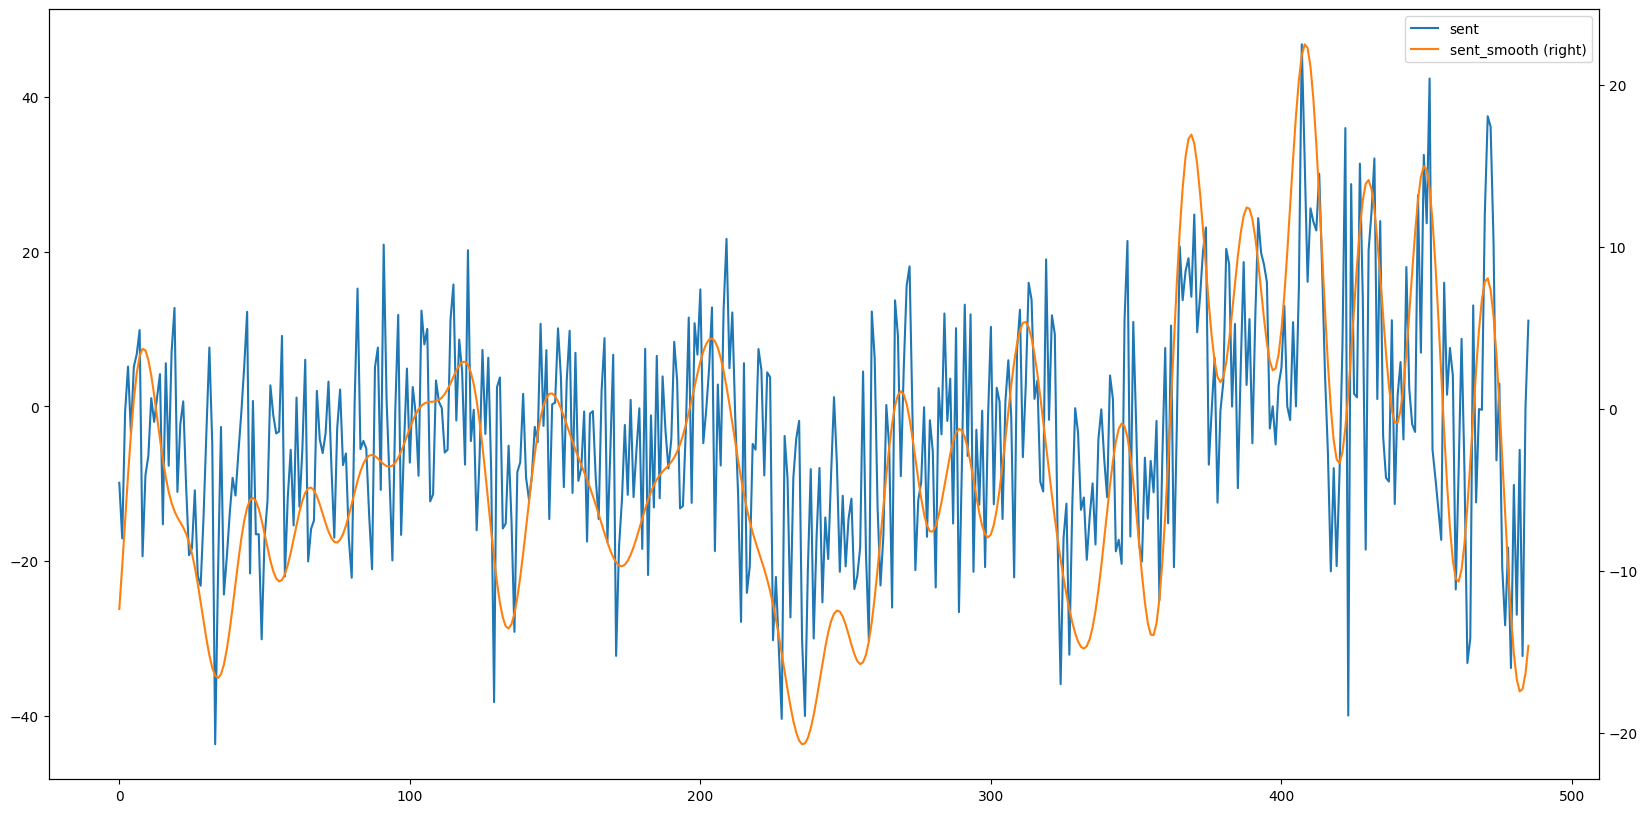

In [32]:
df[['sent', 'sent_smooth']].plot(secondary_y='sent_smooth', figsize=(20, 10));

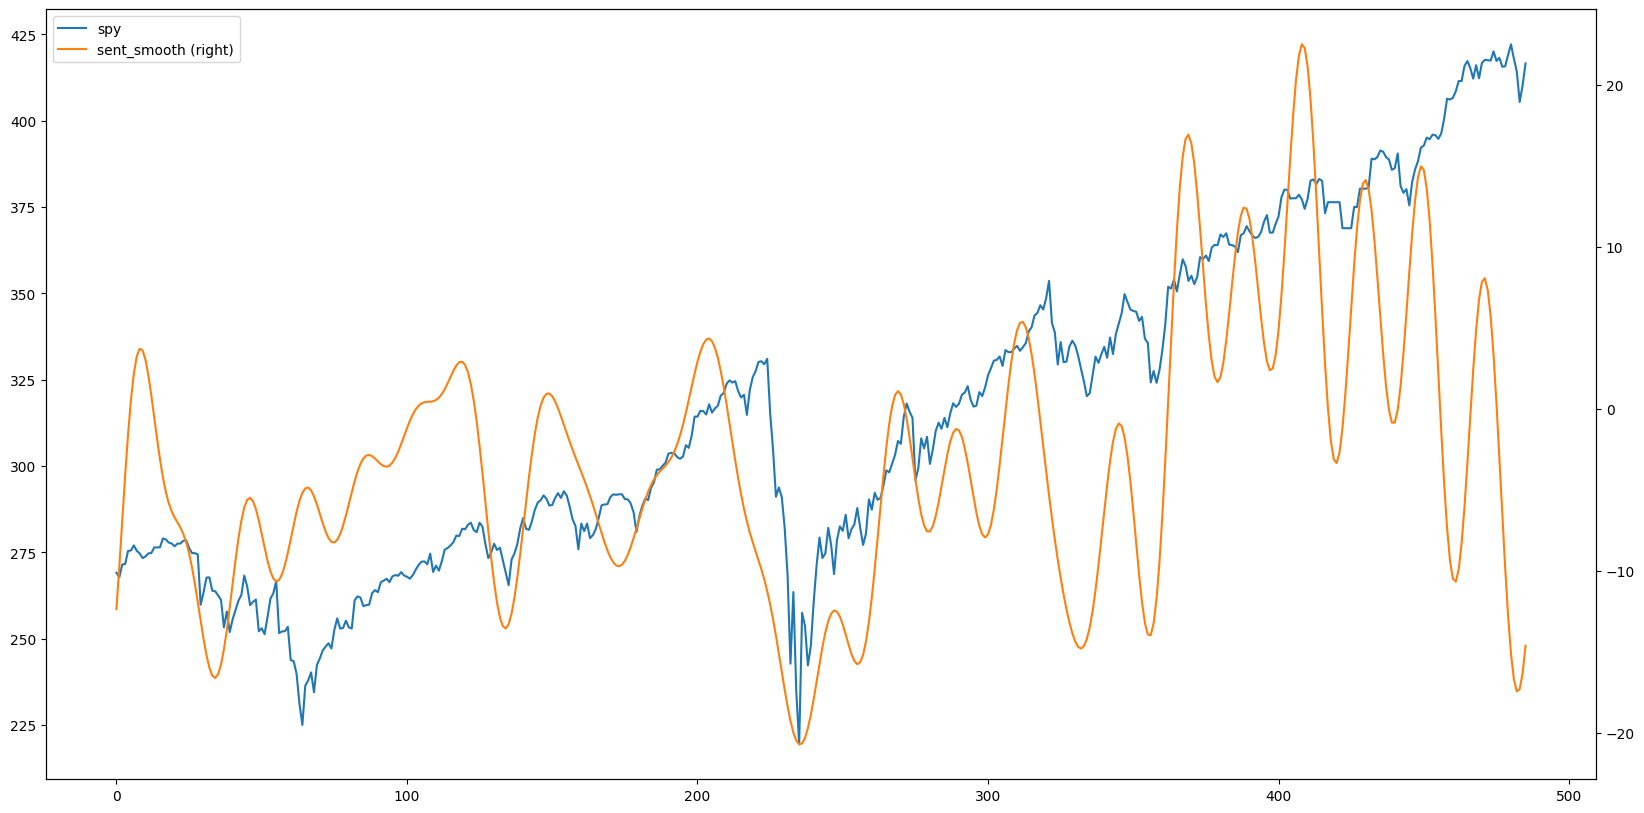

In [33]:
# Smoothes Score against SPY Prices
df[['spy', 'sent_smooth']].plot(secondary_y='sent_smooth', figsize=(20, 10));

There seems to some indication of a correlation. 
- When there is high sentiment, there is an indication that prices are starting to fall

#### 3.2 Correlation between Daily Returns and Sentiment Scores

In [34]:
# Prepare data, extracting year, month, week and weekday in seperate columns
df['year'] = [d.year for d in df.date] # year
df['month'] = [d.strftime('%b') for d in df.date] # month
df['week'] = [d.strftime('%V') for d in df.date] # week number
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'} # prepare weekday
df['weekday'] = df['date'].dt.dayofweek.map(dayOfWeek) # create weekday
years = df['year'].unique() # fill in years
# create return column for spy prices
df['return %']= ((df['spy'][:-1].values / df['spy'][1:] - 1) *100) # caluclate daily returns
df.head(5)

,spy,date,sent,fourier 25,sent_smooth,year,month,week,weekday,return %
0,269.115723,2018-08-10,-9.8812,-12.354836+ 0.783686j,-12.354836,2018,Aug,32,Friday,NaN
1,267.804230,2018-08-15,-17.0701,-9.707922+ 0.404149j,-9.707922,2018,Aug,33,Wednesday,0.489721
2,271.501343,2018-08-20,-0.7095,-6.893142- 0.017240j,-6.893142,2018,Aug,34,Monday,-1.361729
3,271.615356,2018-08-23,5.1418,-4.120512- 0.436845j,-4.120512,2018,Aug,34,Thursday,-0.041976
4,275.407410,2018-08-27,-3.4124,-1.582551- 0.811210j,-1.582551,2018,Aug,35,Monday,-1.376889


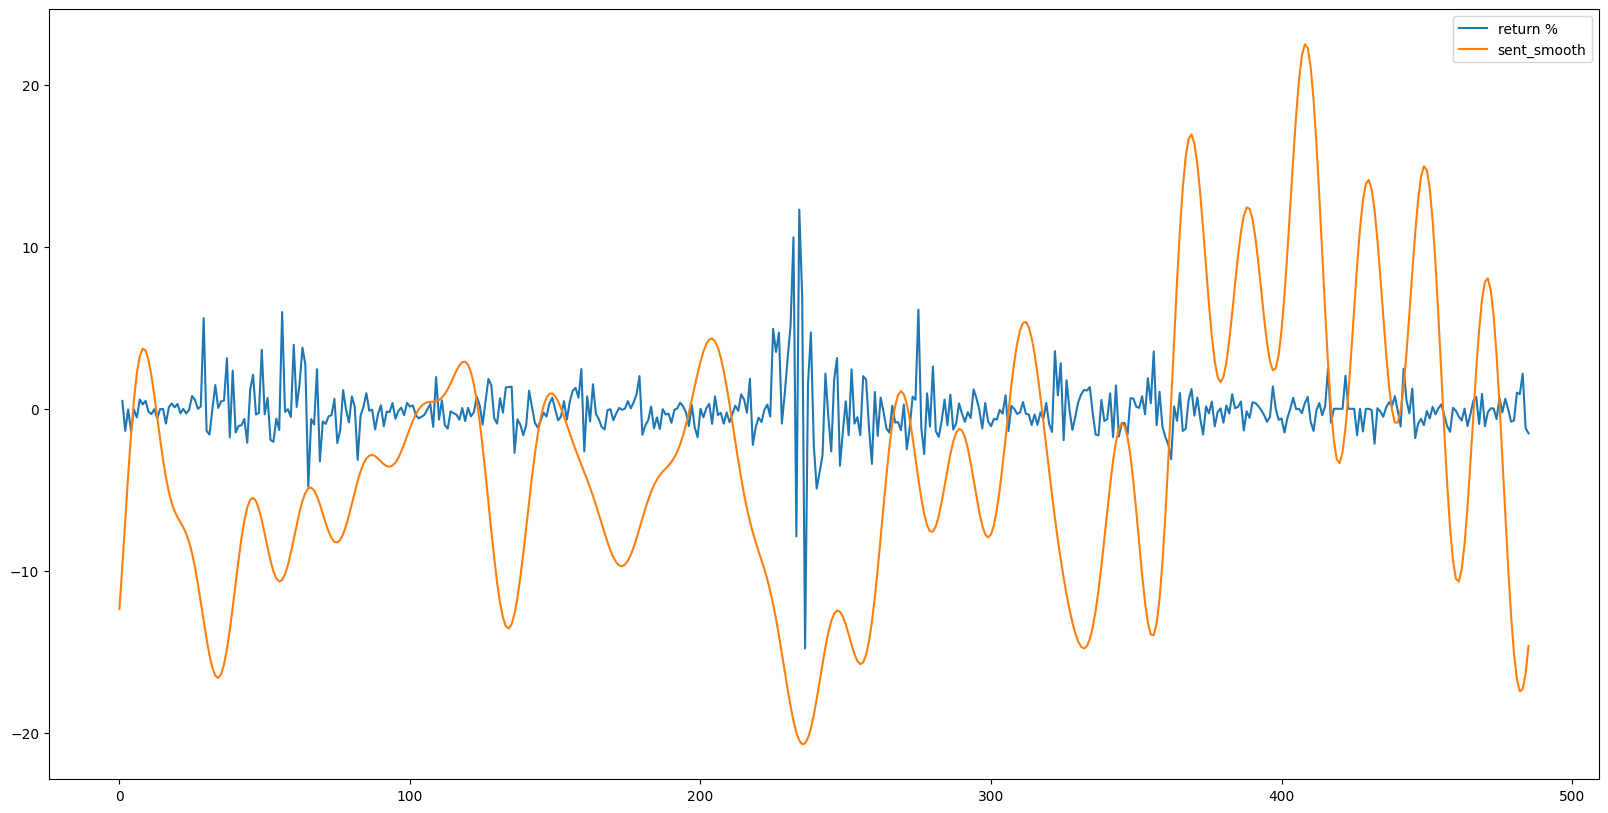

In [35]:
df[['return %', 'sent_smooth', ]].plot(secondary_y='sent_norm', figsize=(20, 10));

Does not seem to be a visible correlation between the daily returns and the sentiment except at the extremes 

#### 3.3 Sentiment Score across a year

In [36]:
# Generate random colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

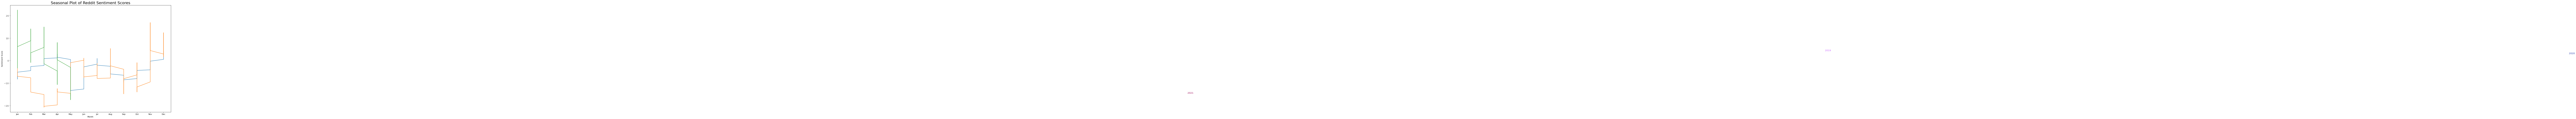

In [37]:
# Draw Plot
plt.figure(figsize=(15,10), dpi=80)

for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'sent_smooth',data=df.loc[df.year==y, :], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'sent_smooth'][-1:].values[0], y, fontsize=12, color=mycolors[i])
        
plt.gca().set(ylabel='Sentiment Score', xlabel='Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Reddit Sentiment Scores", fontsize=20)
plt.show() 

The most positive sentiment seems to happen at the beginning and end of the year
There is a decline during the summer months of June and July 

#### 3.4 Boxplots of Seasonal Sentiment Score 

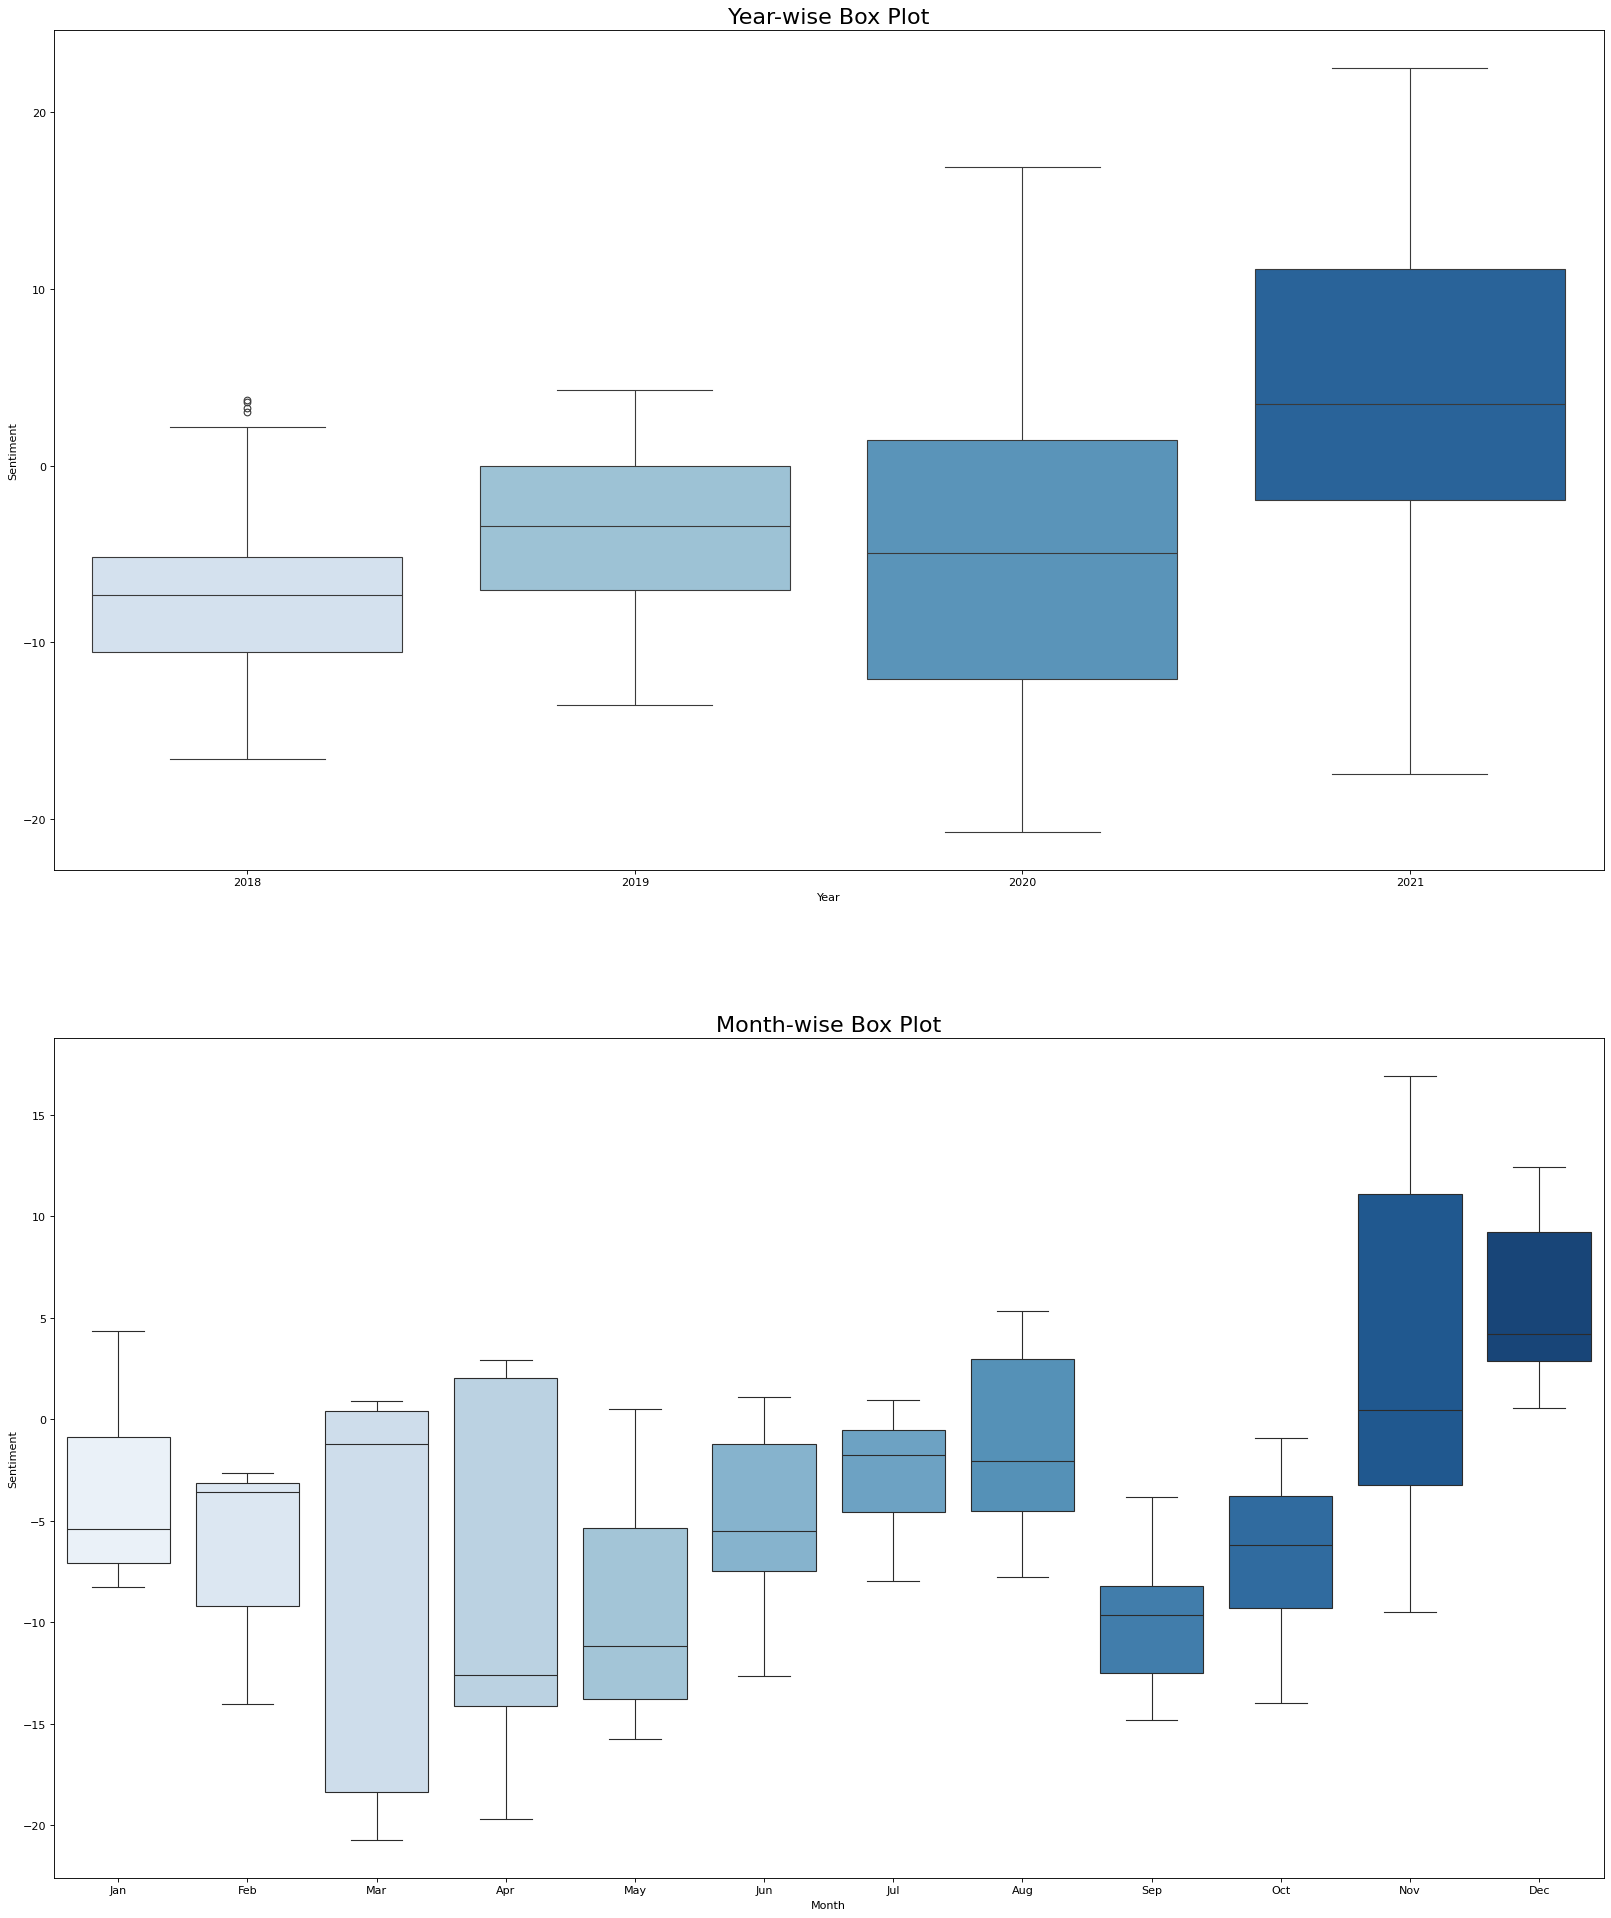

In [38]:
# Draw yearly and monthtly plots

fig, axes = plt.subplots(2, 1, figsize=(25,30), dpi= 80)

sn.boxplot(x='year', y='sent_smooth',palette="Blues",data=df, ax=axes[0]);
sn.boxplot(x='month', y='sent_smooth', palette="Blues", data=df.loc[~df.year.isin([2018, 2021]), :]);

# Set Titles
plt.rcParams["axes.labelsize"] = 20
axes[0].set_title('Year-wise Box Plot', fontsize=20); 
axes[1].set_title('Month-wise Box Plot', fontsize=20);
axes[0].set(xlabel='Year', ylabel='Sentiment')
axes[1].set(xlabel='Month', ylabel='Sentiment')

plt.show();

#### Trends in the Monthly and Yearly boxplots
- Sentiment seems to have increased over the course of the time series. This is likely due to increased market participation during 2018-2021
- The highest sentiment frequently appears at the end of the year
- There is a drop in sentiment during the month of September

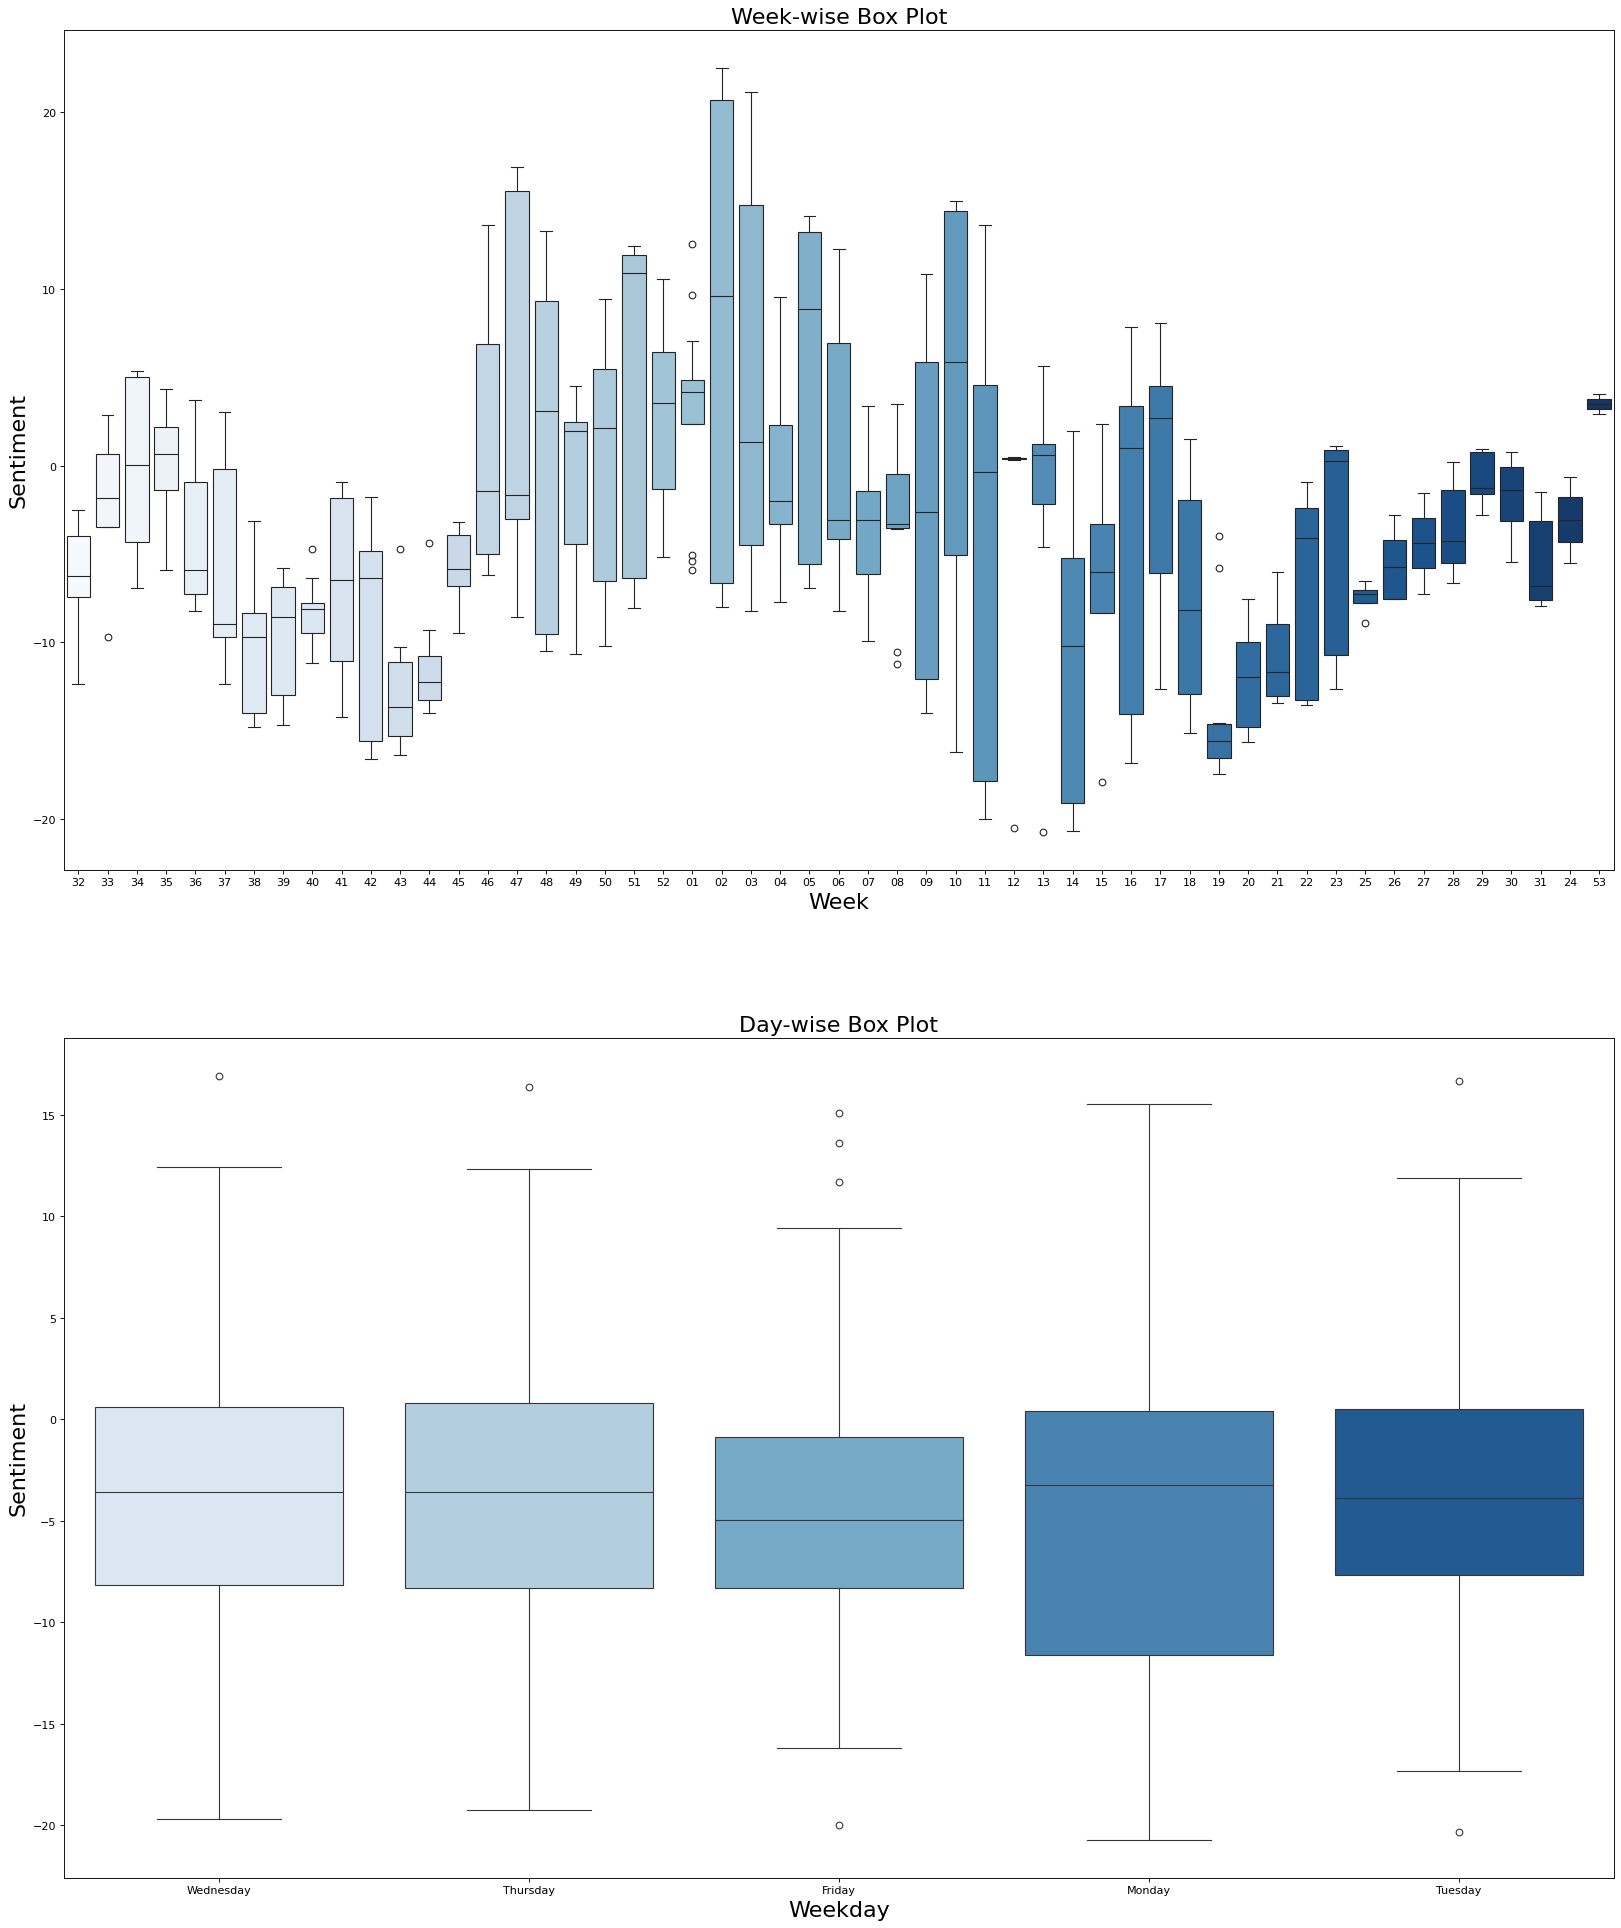

In [39]:
#Draw weekly and weekday plota

fig, axes = plt.subplots(2, 1, figsize=(25,30), dpi= 80)

sn.boxplot(x='week', y='sent_smooth',palette="Blues",data=df, ax=axes[0]);
sn.boxplot(x='weekday', y='sent_smooth', palette="Blues", data=df.loc[~df.year.isin([2018, 2021]), :]);

# Set Titles
plt.rcParams["axes.labelsize"] = 20
axes[0].set_title('Week-wise Box Plot', fontsize=20); 
axes[1].set_title('Day-wise Box Plot', fontsize=20);
axes[0].set(xlabel='Week', ylabel='Sentiment')
axes[1].set(xlabel='Weekday', ylabel='Sentiment')

plt.show();

#### Trends in Weekly and Weekday Plots
- Sentiment varies a lot on individual weekdays, there does not seem to be a consistent trend
- Can see the seasonal drop in the weekly plots which correlate which the monthly plots

#### Seasonality of Returns 

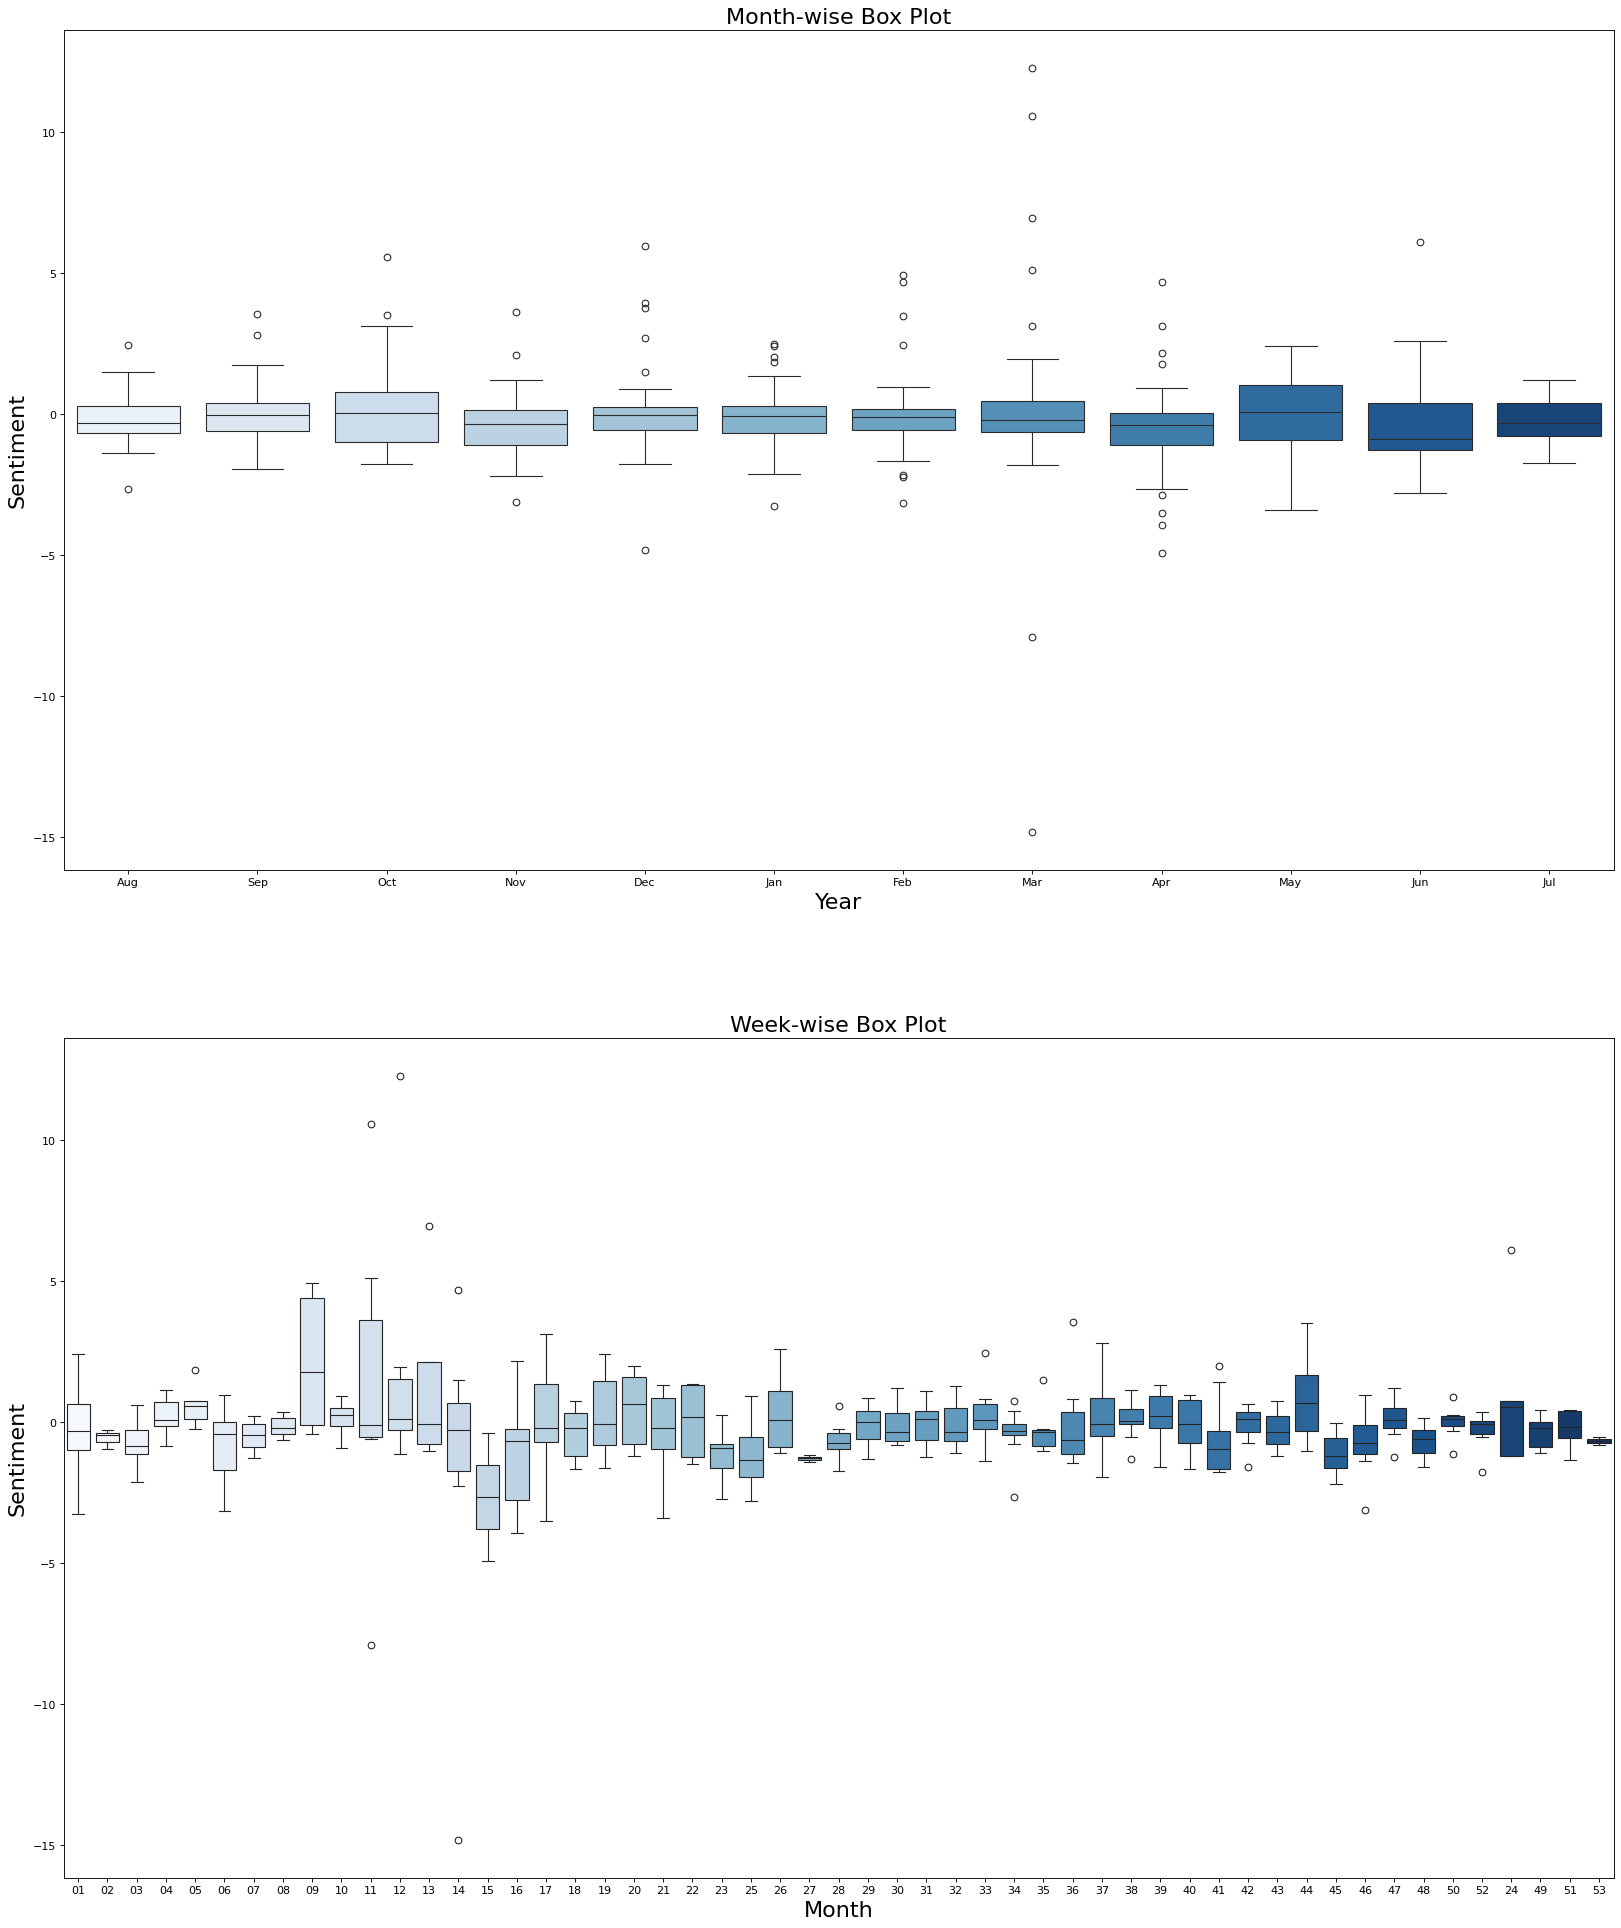

In [40]:
## Now doing the same for price returns
# Draw yearly and monthtly plots

fig, axes = plt.subplots(2, 1, figsize=(25,30), dpi= 80)

sn.boxplot(x='month', y='return %',palette="Blues",data=df, ax=axes[0]);
sn.boxplot(x='week', y='return %', palette="Blues", data=df.loc[~df.year.isin([2018, 2021]), :]);

# Set Titles
plt.rcParams["axes.labelsize"] = 20
axes[0].set_title('Month-wise Box Plot', fontsize=20); 
axes[1].set_title('Week-wise Box Plot', fontsize=20);
axes[0].set(xlabel='Year', ylabel='Sentiment')
axes[1].set(xlabel='Month', ylabel='Sentiment')

plt.show();